## **Data Prepration**

In [ ]:
import numpy as np
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import accuracy_score

In [ ]:
## Read in the dataset
import pandas as pd
link = "https://github.com/vickybwu/Myfiles/blob/main/Womens%20Clothing%20E-Commerce%20Reviews.csv?raw=true"
clothing_store = pd.read_csv(link)

In [ ]:
clothing_store.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
## Only using two columns
my_data = clothing_store[['Review Text', 'Recommended IND']].dropna()

In [ ]:
## Randomly Select n data points from each class
## Let n be 1000
import random

recommended_reviews = my_data[my_data['Recommended IND'] == 1]
not_recommended_reviews = my_data[my_data['Recommended IND'] == 0]

indexes_1 = random.sample(range(0, len(recommended_reviews)), 1000)
indexes_2 = random.sample(range(0, len(not_recommended_reviews)), 1000)

recommended_reviews = recommended_reviews.iloc[indexes_1]
not_recommended_reviews = not_recommended_reviews.iloc[indexes_2]

selected = recommended_reviews.append(not_recommended_reviews, ignore_index = True)

# shuffle the DataFrame rows 
selected = selected.sample(frac = 1) 
selected = selected.reset_index(drop=True)

selected.head()

,Review Text,Recommended IND
0,Overall a very nice and unique dress. it does ...,1
1,Love this dress so much! i bought the cranberr...,1
2,"Great peplum top, beautiful whine color. very ...",1
3,I love this tunic! with that said the reason i...,1
4,This sweater dress color is great and texture ...,0


In [ ]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
## Covert reviews into bag of words 

# convert to lowercase string 
selected['Cleaned_Text'] = [str(review) for review in selected['Review Text']]
selected['Cleaned_Text'] = [review.lower() for review in selected['Cleaned_Text']]
# Strip all punctuation and numeric values from each review
table = str.maketrans('', '', string.punctuation)
selected['Cleaned_Text'] = [review.translate(table) for review in selected['Cleaned_Text']]
#  Tokenization : In this each entry in the corpus will be broken into set of words
selected['Cleaned_Text'] = [word_tokenize(review) for review in selected['Cleaned_Text']]

selected.head()

,Review Text,Recommended IND,Cleaned_Text
0,Overall a very nice and unique dress. it does ...,1,"[overall, a, very, nice, and, unique, dress, i..."
1,Love this dress so much! i bought the cranberr...,1,"[love, this, dress, so, much, i, bought, the, ..."
2,"Great peplum top, beautiful whine color. very ...",1,"[great, peplum, top, beautiful, whine, color, ..."
3,I love this tunic! with that said the reason i...,1,"[i, love, this, tunic, with, that, said, the, ..."
4,This sweater dress color is great and texture ...,0,"[this, sweater, dress, color, is, great, and, ..."


In [ ]:
## Remove words with less semantic meaning and lemmatize

# create tag map  (code took from https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python)
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

# Remove Stop words, Non-Numeric and perfom word Lemmenting.
for index,review in enumerate(selected['Cleaned_Text']):
    Final_words = []
    
    Word_Lemmatized = WordNetLemmatizer()
    # identify if the word is Noun(N) or Verb(V) or something else using post tag
    for word, tag in pos_tag(review):
        # remove stop words
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = Word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'cleaned_text'(in the format of lists) and 'text_final'(in the format of strings)
    selected.at[index,'Cleaned_Text'] = Final_words
    selected.loc[index, 'Text_Final'] = str(Final_words)
    
selected.head()

,Review Text,Recommended IND,Cleaned_Text,Text_Final
0,Overall a very nice and unique dress. it does ...,1,"[overall, nice, unique, dress, much, go, wear,...","['overall', 'nice', 'unique', 'dress', 'much',..."
1,Love this dress so much! i bought the cranberr...,1,"[love, dress, much, buy, cranberry, color, fir...","['love', 'dress', 'much', 'buy', 'cranberry', ..."
2,"Great peplum top, beautiful whine color. very ...",1,"[great, peplum, top, beautiful, whine, color, ...","['great', 'peplum', 'top', 'beautiful', 'whine..."
3,I love this tunic! with that said the reason i...,1,"[love, tunic, say, reason, give, star, materia...","['love', 'tunic', 'say', 'reason', 'give', 'st..."
4,This sweater dress color is great and texture ...,0,"[sweater, dress, color, great, texture, nice, ...","['sweater', 'dress', 'color', 'great', 'textur..."


## **Multinomial Naive Bayes Model (built from scratch) with Bog of Words approach**



In [ ]:
## P(c)    
def Priors(Train_set):
    priors = {}
    
    is_not_recommended = Train_set["Recommended IND"] == 0
    Not_Recommended = Train_set[is_not_recommended]
    
    recommended = Train_set["Recommended IND"] == 1
    Recommended = Train_set[recommended]
    
    priors['Recommended'] = len(Recommended)/len(Train_set)
    priors['Not_Recommended'] = len(Not_Recommended)/len(Train_set)
    
    return priors

In [ ]:
## P(d|c)
from collections import Counter

def Likelihood(Train_set, evidence): # Given one piece of evidence
    likelihood = {}

    # Seperate the training set into Recommended and Not Recommended subsets
    is_recommended = Train_set["Recommended IND"] == 1
    Recommended = Train_set[is_recommended]
    
    is_not_recommended = Train_set["Recommended IND"] == 0
    Not_Recommended = Train_set[is_not_recommended]

    
    # Create dictionary for the R subset - Word: frequency

    wordlistR = []
    for review in Recommended['Cleaned_Text']:
        for word in review:
          wordlistR.append(str(word))

    FrequencyR = Counter(wordlistR)

    total_count_r = sum(FrequencyR.values())
    
   #print(FrequencyR)

    
    # Create dictionary for the NR subset - Word: frequency
    wordlistNR = []
    for review in Not_Recommended['Cleaned_Text']:
        for word in review:
          wordlistNR.append(str(word))

    FrequencyNR = Counter(wordlistNR)

    total_count_nr = sum(FrequencyNR.values())
    
    #print(FrequencyNR)

    # For "Recommended" Class, calculate the likelihood of each word and multiply them, to avoid underflow, we add 1 to each word count
    Probability_R = 1
    for word in evidence:
        probs_r = (FrequencyR[word] + 1)/total_count_r
        #print(probs_r)
        Probability_R *= probs_r 
        
    # For "Not_Recommended" Class, calculate the likelihood of each word and multiply them, to avoid underflow, we add 1 to each word count
    Probability_NR = 1
    for word in evidence:
        probs_nr = (FrequencyNR[word] + 1)/total_count_nr
        Probability_NR *= probs_nr 
        
    likelihood["Recommended"] = Probability_R
    likelihood["Not_Recommended"] = Probability_NR
    
    return likelihood
        

In [ ]:
def Posteriors(Train_set, evidence): # Given one piece of evidence
    posteriors = {}
    
    # For recommended 
    prior_recommended = Priors(Train_set)['Recommended']
    likelihood_recommended = Likelihood(Train_set, evidence)['Recommended']
    posterior_recommended = prior_recommended * likelihood_recommended
    
    # For not recommended
    prior_unrecommended = Priors(Train_set)['Not_Recommended']
    likelihood_unrecommended = Likelihood(Train_set, evidence)['Not_Recommended']
    posterior_unrecommended = prior_unrecommended * likelihood_unrecommended
    
    posteriors['Recommended'] = posterior_recommended
    posteriors['Not_Recommended'] = posterior_unrecommended
    
    return posteriors

In [ ]:
def decision_rule(Train_set, evidence):
    posteriors = Posteriors(Train_set, evidence)
    decision_class =  max(posteriors, key = posteriors.get)
    return decision_class

In [ ]:
def evaluate_accuracy(Train_set, Test_set):
    y_true = []
    for x in Test_set['Recommended IND']:
        if x == 1:
            y_true.append('Recommended')
        if x == 0:
            y_true.append('Not_Recommended')
    #print(y_true)
        
    y_predicted = []
    for evidence in Test_set['Cleaned_Text']:
        prediction = decision_rule(Train_set, evidence)
        y_predicted.append(prediction)
    #print(y_predicted)
        
    
    accuracy = 0
    for i in range(len(y_true)):
        if y_true[i] == y_predicted[i]:
            accuracy += 1
            
    return accuracy/float(len(y_true))

In [ ]:
## Train-Set split of 80-20

test_size = int(len(selected)*0.2)

indexes = random.sample(range(0, len(selected)), test_size)

Test_set = selected.iloc[indexes]

Train_set = selected.drop(indexes)

In [ ]:
accuracy_score = evaluate_accuracy(Train_set, Test_set)

print("The accuracy rate from the test set is", accuracy_score)

The accuracy rate from the test set is 0.8575


# **Using SKlearn Models: Naive Bayes, KMeans, Logistic Regression, SVM**

## **TFIDF Score Vectorization, no scaling, no dimension reduction**

Train_Test_Split

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train,y_test = train_test_split(selected['Text_Final'], selected['Recommended IND'], test_size = 0.2,
                                                   random_state = 25)


In [ ]:
##  TFIDF Vectorization

from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorization using tf-idf scores
# There are only less than 5000 features (words) in the dataset, set max_feature to 5000 to include all the features
tfidfvector = TfidfVectorizer(max_features = 5000)
tfidfvector.fit(selected['Text_Final'])
TrainX_transformed = tfidfvector.transform(x_train)
TestX_transformed = tfidfvector.transform(x_test)


In [ ]:
tfidf_df = pd.DataFrame(TrainX_transformed.toarray(), columns = tfidfvector.get_feature_names())
tfidf_df


,aa,aaaaannnnnnd,aaahed,abdomen,able,abovetheknee,absolute,absolutely,absurd,abt,abundance,abut,accent,accentuate,accentuated,accentuates,accessorize,accessorizes,accessory,accidentally,acco,accommodates,accompany,accord,accordinglythis,accurate,accurately,achieve,across,acrylic,acrylicwool,act,active,actual,actuality,actually,add,added,addict,addition,...,xspwas,xtr,xx,xxl,xxs,xxsit,xxsmall,xxsp,yak,yarn,yay,yeah,year,yellow,yellowbeige,yellowed,yellowish,yes,yesterday,yet,yetthough,yield,yikes,yoga,yoke,yoself,youd,youll,young,youre,youthfull,youve,yr,yuk,zero,zip,zippedfor,zipper,zoolanders,zuma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.212044,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.155333,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.16981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.

**Classification using different models on unscaled TFIDF scores without dimension reduction**

In [ ]:
## Using K Means Clustering from sklearn without PCA
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters = 2)
kmeans_model.fit(TrainX_transformed,y_train)
prediction = kmeans_model.predict(TestX_transformed)
accuracy = accuracy_score(prediction, y_test)
print("KMeans produced an accuracy score of", accuracy, "on the test set")

KMeans produced an accuracy score of 0.495 on the test set


In [ ]:
## Using SVM from sklearn without PCA
svm_model = svm.SVC(kernel = 'rbf', gamma = 'scale')

svm_model.fit(TrainX_transformed, y_train)

score = svm_model.score(TestX_transformed, y_test)

print("SVM produced an accuracy score of", score, "on the test set")

SVM produced an accuracy score of 0.8525 on the test set


In [ ]:
## Using Logistic Regression without regularization without PCA
from sklearn.linear_model import LogisticRegression

logit_model = LogisticRegression(penalty = 'none').fit(TrainX_transformed, y_train)
score = logit_model.score(TestX_transformed, y_test)
print("Logistic regression without penalty produced an accuracy score of", score, "on the test set")

Logistic regression without penalty produced an accuracy score of 0.7925 on the test set


In [ ]:
## Using Logistic Regression with L2 penalty wihtout PCA

from sklearn.linear_model import LogisticRegression

logit_model_2= LogisticRegression(penalty = 'l2').fit(TrainX_transformed, y_train)
score = logit_model_2.score(TestX_transformed, y_test)
print("Logistic regression produced an accuracy score of", score, "on the test set")

Logistic regression produced an accuracy score of 0.8525 on the test set


## **TFIDF Score Vectorization, Scaled between 0-1, no dimension reduction**

In [ ]:
## Scale all the TFIDF scores to be in between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaled_xtrain = MinMaxScaler().fit_transform(TrainX_transformed.toarray())
scaled_xtest = MinMaxScaler().fit_transform(TestX_transformed.toarray())

In [ ]:
from sklearn.naive_bayes import GaussianNB
# The feature values are not normally distributed but trying the model 

gaussian_model = GaussianNB()
gaussian_model.fit(scaled_xtrain, y_train)
prediction = gaussian_model.predict(scaled_xtest)
accuracy = accuracy_score(prediction, y_test)
print("Gaussian Naive Bayes produced an accuracy score of", accuracy, "on the test set")

Gaussian Naive Bayes produced an accuracy score of 0.6625 on the test set


In [ ]:
## Using K Means Clustering from sklearn without PCA

kmeans_model = KMeans(n_clusters = 2)
kmeans_model.fit(scaled_xtrain,y_train)
prediction = kmeans_model.predict(scaled_xtest)
accuracy = accuracy_score(prediction, y_test)
print("KMeans produced an accuracy score of", accuracy, "on the test set")

KMeans produced an accuracy score of 0.33 on the test set


In [ ]:
## Using SVM from sklearn without PCA
svm_model = svm.SVC(kernel = 'rbf', gamma = 'scale')

svm_model.fit(scaled_xtrain, y_train)

score = svm_model.score(scaled_xtest, y_test)

print("SVM produced an accuracy score of", score, "on the test set")

SVM produced an accuracy score of 0.8125 on the test set


In [ ]:
## Using Logistic Regression without regularization without PCA

logit_model = LogisticRegression(penalty = 'none').fit(scaled_xtrain, y_train)
score = logit_model.score(scaled_xtest, y_test)
print("Logistic regression without penalty produced an accuracy score of", score, "on the test set")

Logistic regression without penalty produced an accuracy score of 0.785 on the test set


In [ ]:
## Using Logistic Regression with L2 penalty wihtout PCA

logit_model_2= LogisticRegression(penalty = 'l2').fit(scaled_xtrain, y_train)
score = logit_model_2.score(scaled_xtest, y_test)
print("Logistic regression produced an accuracy score of", score, "on the test set")

Logistic regression produced an accuracy score of 0.815 on the test set


## **TFIDF Score Vectoriaztion, Data Scaling, PCA**

In [ ]:
from sklearn.decomposition import PCA

# Vectorization on original text data 
tfidfvector = TfidfVectorizer(max_features = 5000)
tfidf_scores = tfidfvector.fit_transform(selected['Text_Final'])

## Scale all the TFIDF scores to be in between 0 and 1 using MinMaxScaler before PCA
from sklearn.preprocessing import MinMaxScaler
scaled_scores = MinMaxScaler().fit_transform(tfidf_scores.toarray())

# Reduce dimension using PCA to keep 95% explained variance 
pca = PCA(n_components = 0.95)

reduced_tfidf = pca.fit_transform(scaled_scores)

x_train, x_test, y_train,y_test = train_test_split(reduced_tfidf, selected['Recommended IND'], test_size = 0.2,
                                                   random_state = 30)


In [ ]:
# Examine the correlation coefficients between two random features
# If the coefficient is too small PCA probably won't help with classification accuracy
print("Pick two random features")
I =  np.random.randint(0, 4000, 50)
for i in I:
  x = tfidf_scores.toarray().T[i]
  y = tfidf_scores.toarray().T[i+1]
  r = np.corrcoef(x, y)
  print("The coefficient between feature", i, "and feature", i+1, "is", r[0,1])

Pick two random features
The coefficient between feature 1602 and feature 1603 is -0.0007075541938640144
The coefficient between feature 2993 and feature 2994 is -0.0007064425904667866
The coefficient between feature 3478 and feature 3479 is -0.0038105107133215924
The coefficient between feature 818 and feature 819 is -0.0005002501250625325
The coefficient between feature 3669 and feature 3670 is -0.0007023054485455137
The coefficient between feature 3299 and feature 3300 is -0.012190476767178557
The coefficient between feature 3704 and feature 3705 is -0.004975321708055041
The coefficient between feature 1996 and feature 1997 is -0.0011968399214793038
The coefficient between feature 1066 and feature 1067 is -0.00050025012506253
The coefficient between feature 170 and feature 171 is -0.0005002501250625304
The coefficient between feature 1536 and feature 1537 is -0.009206924035801532
The coefficient between feature 3660 and feature 3661 is -0.0025968600040935617
The coefficient between 

In [ ]:
print("After PCA, we reduced the dimensionality of the training data to", x_train.shape[1])
print("After PCA, we reduced the dimensionality of the testing data to", x_test.shape[1])

After PCA, we reduced the dimensionality of the training data to 1316
After PCA, we reduced the dimensionality of the testing data to 1316


In [ ]:
from sklearn.naive_bayes import GaussianNB
# feature values are not normally distributed but trying the model
gaussian_model = GaussianNB()
gaussian_model.fit(x_train, y_train)
prediction = gaussian_model.predict(x_test)
accuracy = accuracy_score(prediction, y_test)
print("Gaussian Naive Bayes produced an accuracy score of", accuracy, "on the test set")

Gaussian Naive Bayes produced an accuracy score of 0.5325 on the test set


In [ ]:
## Using K Means Clustering from sklearn with PCA
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters = 2)
kmeans_model.fit(x_train,y_train)
prediction = kmeans_model.predict(x_test)
accuracy = accuracy_score(prediction, y_test)
print("KMeans produced an accuracy score of", accuracy, "on the test set")

KMeans produced an accuracy score of 0.6625 on the test set


In [ ]:
## Using SVM from sklearn with PCA
svm_model = svm.SVC(kernel = 'rbf', gamma = 'scale')

svm_model.fit(x_train, y_train)

score = svm_model.score(x_test, y_test)

print("SVM produced an accuracy score of", score, "on the test set")

SVM produced an accuracy score of 0.84 on the test set


In [ ]:
## Using Logistic Regression without regularization with PCA
from sklearn.linear_model import LogisticRegression
logit_model = LogisticRegression(penalty = 'none').fit(x_train, y_train)
score = logit_model.score(x_test, y_test)
print("Logistic regression without penalty produced an accuracy score of", score, "on the test set")

Logistic regression without penalty produced an accuracy score of 0.7875 on the test set


In [ ]:
## Using Logistic Regression with L2 penalty wiht PCA

logit_model_2= LogisticRegression(penalty = 'l2').fit(x_train, y_train)
score = logit_model_2.score(x_test, y_test)
print("Logistic regression produced an accuracy score of", score, "on the test set")


Logistic regression produced an accuracy score of 0.83 on the test set


## **TFIDF Scores, Data Scaling and LDA for classification**

In [ ]:
## Use LDA to reduce dimensionality to 2
from sklearn.preprocessing import MinMaxScaler

tfidfvector = TfidfVectorizer(max_features = 5000)
tfidf_scores = tfidfvector.fit_transform(selected['Text_Final'])

## Scare the entire tfidf score vector 
scaled_scores = MinMaxScaler().fit_transform(tfidf_scores.toarray())

## train test split
x_train, x_test, y_train, y_test = train_test_split(scaled_scores, selected[['Recommended IND']], test_size = 0.2 )

## fit in LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components = None)
lda.fit(scaled_scores, selected['Recommended IND'].values)
x_train_lda = lda.transform(x_train)                                                                                                              
x_test_lda = lda.transform(x_test)

## Use lda to predict 
predictions = lda.predict(x_test)
accuracy = accuracy_score(predictions, y_test)
print("LDA produced an accuracy score of", accuracy, "on the test set")

LDA produced an accuracy score of 0.9925 on the test set


## **Bag of Words Vectorization, no scaling, no dimension reduction** 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

x_train, x_test, y_train,y_test = train_test_split(selected['Text_Final'], selected['Recommended IND'], test_size = 0.2,
                                                   random_state = 28)

bow_model = CountVectorizer(max_features=5000)
bow_model.fit(selected['Text_Final'])
x_train_transformed = bow_model.transform(x_train)
x_test_transformed = bow_model.transform(x_test)

In [ ]:
## Using Multinomial Naive Bayes
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score

bayes_model = naive_bayes.MultinomialNB()
bayes_model.fit(x_train_transformed, y_train)
# predict the labels on validation dataset
predictions = bayes_model.predict(x_test_transformed)
# Use accuracy_score function to get the accuracy
accuracy = accuracy_score(predictions, y_test)

print("Multinomial Naive Bayes Accuracy Score is ", accuracy)

Multinomial Naive Bayes Accuracy Score is  0.82


In [ ]:
## Using Logistic Regression 
logit_model = LogisticRegression()
logit_model.fit(x_train_transformed, y_train)
score = logit_model.score(x_test_transformed, y_test)
print("Logistic Regression accuracy scroe is", score )

Logistic Regression accuracy scroe is 0.81


In [ ]:
## Using Logistic Regression without penalty
logit_model = LogisticRegression(penalty = 'none')
logit_model.fit(x_train_transformed, y_train)
score = logit_model.score(x_test_transformed, y_test)
print("Logistic Regression accuracy scroe is", score )

Logistic Regression accuracy scroe is 0.48


In [ ]:
## Using K Means 

kmeans_model = KMeans(n_clusters = 2)
kmeans_model.fit(x_train_transformed,y_train)
prediction = kmeans_model.predict(x_test_transformed)
accuracy = accuracy_score(prediction, y_test)
print("KMeans produced an accuracy score of", accuracy, "on the test set")

KMeans produced an accuracy score of 0.53 on the test set


In [ ]:
## Using SVM
svm_model = svm.SVC(kernel = 'rbf', gamma = 'scale')

svm_model.fit(x_train_transformed, y_train)

score = svm_model.score(x_test_transformed, y_test)

print("SVM produced an accuracy score of", score, "on the test set")

SVM produced an accuracy score of 0.8175 on the test set


In [ ]:
## Using in LDA

lda = LDA(n_components = None)
lda.fit(x_train_transformed.toarray(), y_train)

## Use lda to predict 
predictions = lda.predict(x_test_transformed)
accuracy = accuracy_score(predictions, y_test)
print("LDA produced an accuracy score of", accuracy, "on the test set")

LDA produced an accuracy score of 0.645 on the test set


## **RNN**

In [ ]:
## Create a word list for all the left words in the cleaned reviews to be used for encoding

## Organize the words by its frequency from large to small

word_list = []
for review in selected['Cleaned_Text']:
    for word in review:
        word_list.append(str(word))
        
#create a Counter object to map all the words to an integer value which is their frequency, sorted from largest to smallest
# (code took from https://medium.com/@lamiae.hana/a-step-by-step-guide-on-sentiment-analysis-with-rnn-and-lstm-3a293817e314)
from collections import Counter
vocab = Counter(word_list)
vocab = sorted(vocab, key = vocab.get, reverse= True)

# Assign an integer to each word, the integer is the word index plus 1
vocab_int = {word: index  for index, word in enumerate(vocab,1)}


In [ ]:
## Map each review to a list of integers based on the vocabulary map  
## Initialize a list to store all the reviews as a list of integers

integer_list = []

for i in range(len(selected['Cleaned_Text'])):
    review = selected['Cleaned_Text'][i]
    review_int = []
    for word in review:
        review_int.append(vocab_int[word])

    integer_list.append(review_int)
    
selected['Review_Int'] = integer_list

selected.head()

,Review Text,Recommended IND,Cleaned_Text,Text_Final,Review_Int
0,"Great layering top. so comfy, feels soft as my...",1,"[great, layer, top, comfy, feel, soft, pjs, bu...","['great', 'layer', 'top', 'comfy', 'feel', 'so...","[15, 212, 8, 194, 61, 46, 988, 22, 9]"
1,"As much as i wanted to love this top, it was t...",0,"[much, want, love, top, flowy, felt, like, loo...","['much', 'want', 'love', 'top', 'flowy', 'felt...","[36, 35, 5, 8, 230, 141, 6, 2, 50, 11, 3, 176,..."
2,I ordered my usual size and i think the length...,0,"[order, usual, size, think, length, top, chest...","['order', 'usual', 'size', 'think', 'length', ...","[14, 178, 3, 24, 55, 8, 2240, 15, 73, 82, 305,..."
3,"When i unwrapped this a chemical ""stink"" hit m...",0,"[unwrap, chemical, stink, hit, amost, knock, r...","['unwrap', 'chemical', 'stink', 'hit', 'amost'...","[1680, 1681, 1682, 174, 2241, 1400, 19, 2242, ..."
4,"As others have said, this is cropped, so will ...",0,"[others, say, crop, look, funny, pant, arent, ...","['others', 'say', 'crop', 'look', 'funny', 'pa...","[456, 94, 393, 2, 618, 54, 844, 116, 699, 11, ..."


In [ ]:
## Pad sequence

# use pad_sequence function from Keras to pad each review to be of a length of the review with the maximum length of all the reviews 

from keras.preprocessing import sequence

print('The longest review in the data has', max(len(review) for review in selected['Review_Int']), 'words')

# set maximum number of words 
max_words = max(len(review) for review in selected['Review_Int'])
padded_reviews = sequence.pad_sequences(selected['Review_Int'], maxlen = max_words)


In [ ]:
# split the data into training and testing data
x_train, x_test, y_train, y_test = train_test_split(padded_reviews, selected['Recommended IND'].values, test_size = 0.2, random_state =6)


In [ ]:
## Build a RNN (code took from https://towardsdatascience.com/a-beginners-guide-on-sentiment-analysis-with-rnn-9e100627c02e)

from keras import Sequential
from keras.layers import Embedding, LSTM, Dense

model_rnn = Sequential()

embedding_size = 8
model_rnn.add(Embedding(5000, embedding_size, input_length=max_words))
model_rnn.add(LSTM(100))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'] )

model_rnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 58, 8)             40000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               43600     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 83,701
Trainable params: 83,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_rnn.fit(x_train, y_train, epochs = 10, validation_data = (x_test, y_test))

Epoch 1/10
50/50 [==============================] - 2s 39ms/step - loss: 0.0100 - accuracy: 0.9994 - val_loss: 0.7497 - val_accuracy: 0.8125
Epoch 2/10
50/50 [==============================] - 2s 42ms/step - loss: 0.0149 - accuracy: 0.9956 - val_loss: 0.8825 - val_accuracy: 0.7875
Epoch 3/10
50/50 [==============================] - 2s 43ms/step - loss: 0.0174 - accuracy: 0.9975 - val_loss: 0.7983 - val_accuracy: 0.7975
Epoch 4/10
50/50 [==============================] - 2s 42ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.8786 - val_accuracy: 0.8050
Epoch 5/10
50/50 [==============================] - 2s 43ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.9341 - val_accuracy: 0.8025
Epoch 6/10
50/50 [==============================] - 2s 43ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.9518 - val_accuracy: 0.8025
Epoch 7/10
50/50 [==============================] - 2s 41ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.9958 - val_accuracy: 0.8075
Epoch 8/10
50

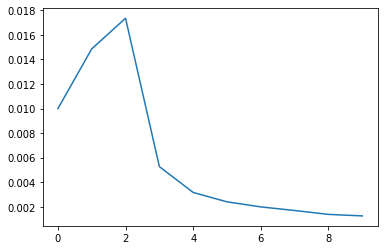

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
scores = model_rnn.evaluate(x_test, y_test)
print('RNN accuracy score on the test set is', scores[1])

13/13 [==============================] - 0s 13ms/step - loss: 1.0719 - accuracy: 0.8100
RNN accuracy score on the test set is 0.8100000023841858
